<h1 style="text-align: center; font-size: 50px;">Scientific Presentation Script Generator with Local LLM & ChromaDB</h1>

This notebook leverages a RAG (Retrieval-Augmented Generation) architecture to generate a scientific presentation script. The process begins by querying the arXiv API for papers related to a specific topic. After retrieving the relevant papers, the notebook applies preprocessing and formatting pipelines to generate a cohesive and informative script.

## Overview

- Start Execution
- Install and Import Libraries
- Configure Settings
- Verify Assets
- Search and download scientific papers  
- Preprocessing (chunking and embedding)  
- Storage in vector database (ChromaDB)  
- Model selection  
- Script generation

## Start Execution

In [1]:
import logging
import time

# Configure logger
logger: logging.Logger = logging.getLogger("run_workflow_logger")
logger.setLevel(logging.INFO)
logger.propagate = False  # Prevent duplicate logs from parent loggers

# Set formatter
formatter: logging.Formatter = logging.Formatter(
    fmt="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

# Configure and attach stream handler
stream_handler: logging.StreamHandler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

In [2]:
start_time = time.time()  

logger.info("Notebook execution started.")

2025-07-11 22:47:30 - INFO - Notebook execution started.


## Install and Import Libraries
This step installs the necessary libraries for the models and text generation pipeline

In [ ]:
%%time

%pip install -r ../requirements.txt --quiet

In [ ]:
# System
import os
import sys
import yaml
import logging
from pathlib import Path
import warnings
import torch
from typing import Dict, Any, Optional, Union, List, Tuple

# Add the src directory to the path to import utils
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.utils import configure_hf_cache
from src.utils import configure_proxy
from src.utils import load_config, load_secrets, load_secrets_to_env
from src.utils import initialize_llm

# Import transformers from huggingface
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

#Import components of notebook
from core.extract_text.arxiv_search import ArxivSearcher
from core.generator.script_generator import ScriptGenerator
from core.analyzer.scientific_paper_analyzer import ScientificPaperAnalyzer
from core.deploy.text_generation_service import TextGenerationService

#import langchain libraries
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.schema import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema import StrOutputParser
from langchain_huggingface import HuggingFacePipeline, HuggingFaceEndpoint
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler
from langchain_community.llms import LlamaCpp

# Libraries from python
from typing import List

## Configure Settings


In [5]:
# Suppress Python warnings
warnings.filterwarnings("ignore")

In [7]:
CONFIG_PATH  = "../configs/config.yaml"
SECRETS_PATH = "../configs/secrets.yaml"
LOCAL_MODEL_PATH = "/home/jovyan/datafabric/meta-llama3.1-8b-Q8/Meta-Llama-3.1-8B-Instruct-Q8_0.gguf"

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Configuration and Secrets Loading

In this section, we load configuration parameters and API keys from separate YAML files. This separation helps maintain security by keeping sensitive information (API keys) separate from configuration settings.

- **config.yaml**: Contains non-sensitive configuration parameters like model sources and URLs
- **secrets.yaml**: Contains sensitive API keys for services like HuggingFace
- *(Optional for Premium users)* Secrets such as API keys for services like HuggingFace can be stored as environment variables for the project and loaded into the notebook (see the project's README file for steps on how to save secrets in Secrets Manager).

In [ ]:
# Load secrets from secrets.yaml file (if it exists) into environment
if Path(SECRETS_PATH).exists():
    load_secrets_to_env(SECRETS_PATH)
else:
    print(f"No secrets file found at {SECRETS_PATH}; relying on preexisting environment")

# Retrieve secrets from environment
try:
    secrets = load_secrets()
except ValueError:
    secrets = {}

# Load configuration and secrets
config = load_config(CONFIG_PATH)

print("✅ Configuration loaded successfully")
print("✅ Secrets loaded successfully")

## Verify Assets

In [ ]:
def log_asset_status(asset_path: str, asset_name: str, success_message: str, failure_message: str) -> None:
    """
    Logs the status of a given asset based on its existence.

    Parameters:
        asset_path (str): File or directory path to check.
        asset_name (str): Name of the asset for logging context.
        success_message (str): Message to log if asset exists.
        failure_message (str): Message to log if asset does not exist.
    """
    if Path(asset_path).exists():
        logger.info(f"{asset_name} is properly configured. {success_message}")
    else:
        logger.info(f"{asset_name} is not properly configured. {failure_message}")

def log_secrets_status(secrets: Dict[str, Any], success_message: str, failure_message: str) -> None:
    """
    Logs the status of secrets based on their existence.

    Parameters:
        secrets (Dict[str, Any]): Secrets retrieved to check if they exist.
        success_message (str): Message to log if secrets exists.
        failure_message (str): Message to log if secrets do not exist.
    """
    if secrets:
        logger.info(f"Project secrets are available. {success_message}")
    else:
        logger.info(f"There are no project secrets found. {failure_message}")


log_asset_status(
    asset_path=CONFIG_PATH,
    asset_name="Config",
    success_message="",
    failure_message="Please check if the configs.yaml was propely connfigured in your project on AI Studio."
)

log_secrets_status(
    secrets=secrets,
    success_message="",
    failure_message="Please check if the secrets were propely connfigured."
)

log_asset_status(
    asset_path=LOCAL_MODEL_PATH,
    asset_name="Local Llama model",
    success_message="",
    failure_message="Please create and download the required assets in your project on AI Studio if you want to use local model."
)

2025-07-11 22:47:35 - INFO - local llama model is properly configured. 
2025-07-11 22:47:35 - INFO - Config is properly configured. 
2025-07-11 22:47:35 - INFO - Secrets is properly configured. 


### Proxy Configuration

For certain enterprise networks, you might need to configure proxy settings to access external services. If this is your case, set up the "proxy" field in your config.yaml and the following cell will configure the necessary environment variable.

In [12]:
configure_proxy(config)

### Configuration of Hugging face caches

In the next cell, we configure HuggingFace cache, so that all the models downloaded from them are persisted locally, even after the workspace is closed. This is a future desired feature for AI Studio and the GenAI addon.

In [13]:
# Configure HuggingFace cache
configure_hf_cache()

In [14]:
# Initialize HuggingFace Embeddings
embeddings = HuggingFaceEmbeddings()

2025-07-11 22:47:35,191 | INFO | PyTorch version 2.6.0 available.
2025-07-11 22:47:35,351 | INFO | Use pytorch device_name: cuda
2025-07-11 22:47:35,352 | INFO | Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


## 📚 Chapter 1: Building the Paper Research and Processing Pipeline
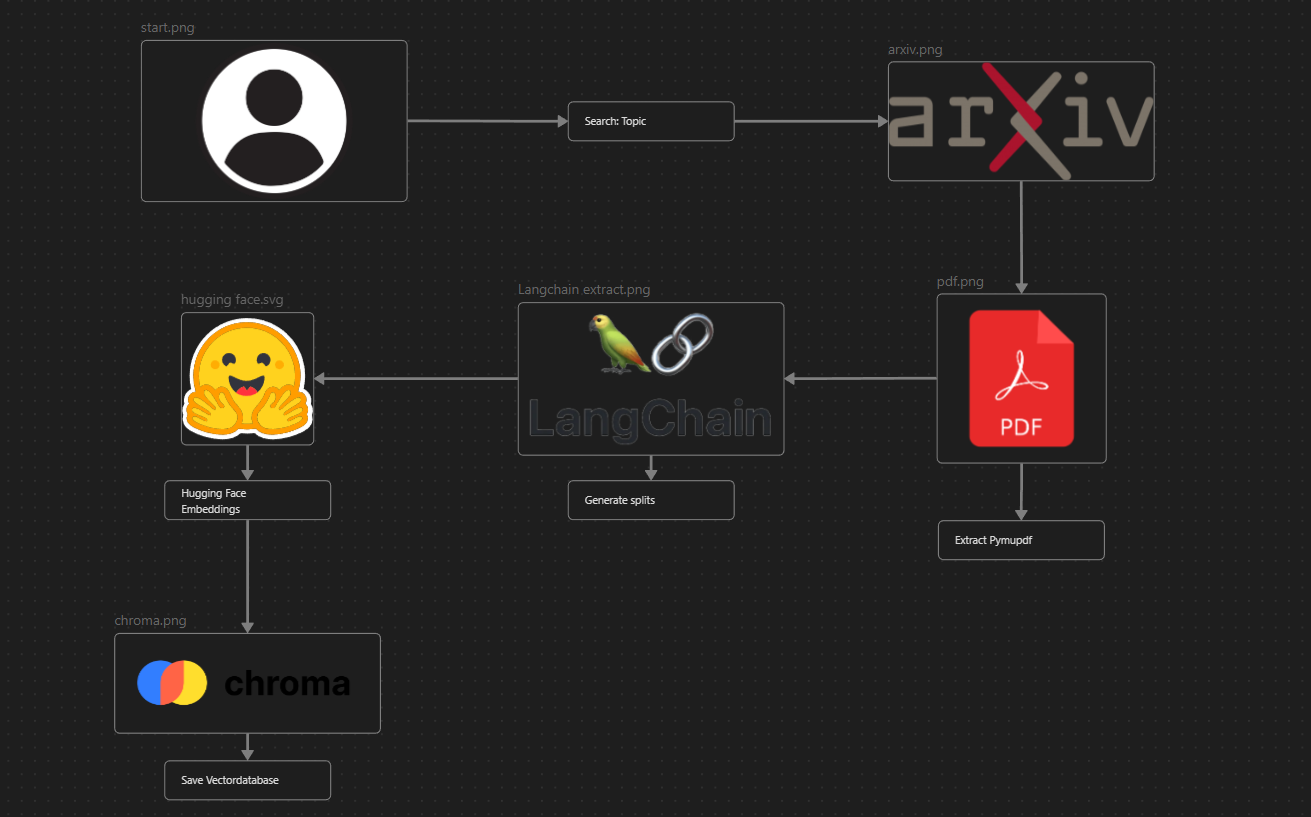
In this chapter, we construct a complete pipeline to search, process, and prepare scientific papers for downstream generation tasks. The workflow is broken down into the following stages:

🔍 **Paper Research**
The process begins by selecting a specific topic and retrieving relevant scientific papers via APIs such as arXiv.

⬇️ **Paper Download**
Once the desired paper is identified, its PDF is downloaded and saved locally for further processing.

🧾 **Text Extraction**
The content of the PDF is extracted using the PyMuPDF library, resulting in a raw text version of the scientific paper.

✂️ **Chunk Creation**
The extracted text is segmented into smaller, manageable units ("chunks") using LangChain's RecursiveCharacterTextSplitter. This enables better contextual handling.

🧠 **Embedding Generation**
Each chunk is transformed into a vector representation (embedding) using HuggingFaceEmbeddings, enabling semantic understanding and searchability.

🧩 **Storage in Vector Database**
The embeddings are then stored in a local vector database powered by ChromaDB, making it possible to perform similarity searches based on content.

> 🚀 This pipeline sets the foundation for a robust RAG (Retrieval-Augmented Generation) system tailored for scientific presentations.

### 🔎 Step 1: Searching Scientific Papers
In this step, we use the arXiv API to find and extract relevant scientific papers based on a topic provided by the user. The process prepares the raw text content that will later be used for generation.

The flow is composed of the following steps:

1. **📝 Define the Query**
The user inputs a keyword or topic of interest. An optional max_results parameter can be configured (default is 1).

2. **🌐 Search on arXiv**
The function search_arxiv_and_extract_text sends a request to the arXiv API using the provided query. The response includes metadata about matching papers.

3. **📄 Parse the Response**
The XML returned by the API is parsed to extract key information such as the paper title and the PDF download link.

4. **⬇️ Download the PDF**
The paper is downloaded locally using the download_pdf function and saved to a temporary directory.

5. **🧾 Extract Raw Text**
The downloaded PDF is parsed using the PyMuPDF library. The extracted text is consolidated and returned as a plain string, which serves as input for the next stages (embedding and generation).

📁 The paper retrieval logic is implemented in `src/extract_text/arxiv_search.py`

In [15]:
searcher = ArxivSearcher(query="large language models", max_results=2, logging_enabled=True)
papers = searcher.search_and_extract()

2025-07-11 22:47:39,928 | INFO | Extracted text from 'Lost in Translation: Large Language Models in Non-English Content
  Analysis':
Lost in Translation
May 2023
A report from
Gabriel Nicholas
Aliya Bhatia
Large Language Models in 
Non-English Content Analysis

GABRIEL NICHOLAS
Research Fellow at the Center for Democracy & Technology.
ALIYA BHATIA
Policy Analyst, Free Expression Project at the Center for 
Democracy & Technology.
...

2025-07-11 22:47:40,288 | INFO | Extracted text from 'Cedille: A large autoregressive French language model':
CEDILLE:
A LARGE AUTOREGRESSIVE LANGUAGE MODEL IN FRENCH
Martin Müller∗
Florian Laurent∗
Cedille AI1
hello@cedille.ai
ABSTRACT
Scaling up the size and training of autoregressive language models has enabled novel ways of solving
Natural Language Processing tasks using zero-shot and few-shot learning....



In [16]:
papers

[{'title': 'Lost in Translation: Large Language Models in Non-English Content\n  Analysis',
  'text': 'Lost in Translation\nMay 2023\nA report from\nGabriel Nicholas\nAliya Bhatia\nLarge Language Models in \nNon-English Content Analysis\n\nGABRIEL NICHOLAS\nResearch Fellow at the Center for Democracy & Technology.\nALIYA BHATIA\nPolicy Analyst, Free Expression Project at the Center for \nDemocracy & Technology.\nThe Center for Democracy & Technology (CDT) is the leading \nnonpartisan, nonprofit organization fighting to advance civil rights and \ncivil liberties in the digital age. We shape technology policy, governance, \nand design with a focus on equity and democratic values. Established in \n1996, CDT has been a trusted advocate for digital rights since the earliest \ndays of the internet. The organization is headquartered in Washington, \nD.C., and has a Europe Office in Brussels, Belgium.\n\nA report from\nGabriel Nicholas and Aliya Bhatia\nWITH CONTRIBUTIONS BY\nSamir Jain, Mallo

### 🧱 Step 2: Processing and Embedding Generation
In this step, we transform the raw text extracted from the papers into structured embeddings that can be stored and retrieved efficiently in the RAG pipeline.

The flow includes three main stages:

1. **📄 Create Document Objects**
The full text of each paper is wrapped into Document objects — a standard structure used by LangChain to manage and manipulate textual data.

2. **✂️ Split Text into Chunks**
Using LangChain's RecursiveCharacterTextSplitter, the documents are segmented into smaller blocks (chunks) based on character limits. This makes the downstream embedding and retrieval process more effective.

The chunk_size parameter defines the maximum length of each chunk.

3. **📊 Generate Embeddings**
Each text chunk is converted into a vector representation (embedding) using HuggingFaceEmbeddings. These embeddings are later used to populate the vector store and serve as the foundation for similarity-based retrieval in the generation step.



In [17]:
# Creates a list of Document objects from the scientific articles in the `papers` variable.
# Each `Document` is created with the article content and a metadata dictionary containing the title.
documents = [Document(page_content=paper['text'], metadata={"title": paper['title']}) for paper in papers]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1200, chunk_overlap=400)
splits = text_splitter.split_documents(documents)

### 🧩 Step 3: Vector Data Storage and Retrieval
This step handles the storage of embeddings into a vector database and configures a retriever to enable similarity-based search — a key component in the RAG pipeline.

🧠 Store Embeddings with Chroma
The segmented text chunks, previously converted into embeddings, are stored in a local vector store using ChromaDB. This enables efficient access to semantically similar information later on.

🔎 Configure the Retriever
After storing the embeddings, a retriever is set up to perform similarity search queries. This retriever is responsible for:

- Receiving a user query or prompt

- Searching through the stored embeddings

- Returning the most relevant chunks based on vector similarity

> 📦 This mechanism allows the generation model to work with only the most relevant information, improving accuracy and reducing hallucinations.

In [18]:
#Our vector database
vectordb = Chroma.from_documents(documents=splits, embedding=embeddings)

2025-07-11 22:47:40,487 | INFO | Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [19]:
retriever = vectordb.as_retriever()

## 🧠 Chapter 2: Building a Prompt Flow for Generating Scientific Presentation Scripts
In this chapter, we build a prompt flow to generate a complete scientific presentation script using LLMs. Each section of the script (e.g., title, introduction, methodology) is created individually through dedicated prompt templates.

The process is composed of four main steps:

1. 🧠 **Model Selection**
Choose the best-suited LLM for the generation task, depending on performance or local availability.

2. 🔍 **Analysis with ScientificPaperAnalyzer**
Using the component ScientificPaperAnalyzer, a custom LangChain chain is built to analyze the scientific paper and generate context-aware responses.

3. 🧾 **Script Generation with Logging**
The ScriptGenerator orchestrates the prompt flow, allowing users to generate each section of the presentation interactively.

#### ⚙️ Step 4: Config Enviroment


### 🧠 Model config

In this notebook, we provide three different options for loading the model:

- **local**: by loading the llama2-7b model from the asset downloaded on the project
- **hugging-face-local** by downloading a DeepSeek model from Hugging Face and running locally
- **hugging-face-cloud** by accessing the Mistral model through Hugging Face cloud API (requires HuggingFace API key saved on secrets.yaml)
  
This choice can be set in the variable model_source below or as an entry in the config.yaml file. The model deployed on the bottom cells of this notebook will load the choice from the config file.

In [20]:
%%time

model_source = config["model_source"]

llm = initialize_llm(model_source, secrets, LOCAL_MODEL_PATH)

CPU times: user 1.32 s, sys: 9.5 s, total: 10.8 s
Wall time: 50.9 s


In [21]:
analyzer = ScientificPaperAnalyzer(retriever=retriever, llm=llm, model_source=model_source, logging_enabled=True)
response = analyzer.analyze("What are the main findings of the paper?")
logger.info(response)

2025-07-11 22:48:34,055 | INFO | Building the LangChain chain...
2025-07-11 22:48:34,056 | INFO | Analyzing prompt: 'What are the main findings of the paper?'
2025-07-11 22:48:34,094 | INFO | Retrieved 4 documents for query: 'What are the main findings of the paper?'
2025-07-11 22:48:34,095 | INFO | Formatted 4 documents into context.
2025-07-11 22:48:34,095 | INFO | Context preview: OHCHR. [perma.cc/Y6MK-SZZ4]
Vallee, H. Q. la, & Duarte, N. (2019). Algorithmic Systems in Education: Incorporating Equity and Fairness When 
Using Student Data. Center for Democracy and Technology. [perma.cc/CC89-ZVNV]
Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kai...
2025-07-11 22:48:39,365 | INFO | Raw model output: The paper analyzes the use of Large Language Models (LLMs) in non-English content analysis. The main findings of the paper are:

1. **Limited availability of LLMs for non-English languages**: Currently, there is a lack of well-trained LLMs for many non-Engli

### ✅ Step 6: Run and Approve
The ScriptGenerator component is responsible for generating each section of the scientific presentation script in an interactive and human-in-the-loop fashion.

In [22]:
generator = ScriptGenerator(chain=analyzer.get_chain(), logging_enabled=True)

# Title
generator.add_section(
    name="title",
    prompt="Generate a clear and concise title for the presentation that reflects the content. Add a subtitle if needed. Respond using natural language only."
)

# Introduction
generator.add_section(
    name="introduction",
    prompt="""Write the introduction of the presentation including:
- Contextualization of the general theme.
- Relevance of the topic, both academically and practically.
- A brief literature review.
- A clear definition of the research problem.
- The specific objectives of the research.
- Hypotheses (if applicable).
Respond using only natural language, no structured format or dictionaries."""
)

# Methodology
generator.add_section(
    name="methodology",
    prompt="""Write the methodology section including:
- Research Design (e.g., experimental, descriptive, exploratory).
- Sample and Population details.
- Data Collection methods.
- Instruments used.
- Data Analysis techniques.
Answer clearly in plain text using natural language only."""
)

# Results
generator.add_section(
    name="results",
    prompt="""Write the results section including:
- Presentation of data (feel free to mention tables or graphs).
- Initial interpretation of the data.
- Comparison with hypotheses (if applicable).
Answer using natural language only. Avoid structured outputs."""
)

# Conclusion
generator.add_section(
    name="conclusion",
    prompt="""Write the conclusion of the study including:
- A synthesis of the main results.
- Response to the research problem.
- The study's academic or practical contributions.
- Final reflections or recommendations.
Respond in full natural text without any structured formatting."""
)

# References
generator.add_section(
    name="references",
    prompt="""List the references for the study:
- Include all sources cited in the presentation.
- Format them according to a recognized citation style (APA, MLA, Chicago, etc.).
Answer in natural language with correct formatting."""
)

# Run and combine
generator.run()

script = generator.get_final_script()
print("Final Script:\n", script)


2025-07-11 22:48:39,370 | INFO | Section 'title' added.
2025-07-11 22:48:39,371 | INFO | Section 'introduction' added.
2025-07-11 22:48:39,372 | INFO | Section 'methodology' added.
2025-07-11 22:48:39,372 | INFO | Section 'results' added.
2025-07-11 22:48:39,372 | INFO | Section 'conclusion' added.
2025-07-11 22:48:39,373 | INFO | Section 'references' added.
2025-07-11 22:48:39,373 | INFO | Running section 'title'.
2025-07-11 22:48:39,373 | INFO | Generating section 'title'…
2025-07-11 22:48:39,388 | INFO | Retrieved 4 documents for query: 'Generate a clear and concise title for the presentation that reflects the content. Add a subtitle if needed. Respond using natural language only.'
2025-07-11 22:48:39,389 | INFO | Formatted 4 documents into context.
2025-07-11 22:48:39,389 | INFO | Context preview: Lost in Translation
CDT Research
32
Academics and civil society have written extensively about how technology companies, 
particularly online service providers, could offer better transpa


>>> [title] Result:
Here is a clear and concise title for the presentation:

**Title:** "Leveraging Transparency in AI Model Development"

**Subtitle:** "Examining the Role of Disclosure in Enhancing Accountability and Trust in Machine Learning Systems"



Approve the result? (y/n):  y


2025-07-11 22:50:58,018 | INFO | Running section 'introduction'.
2025-07-11 22:50:58,018 | INFO | Generating section 'introduction'…
2025-07-11 22:50:58,120 | INFO | Retrieved 4 documents for query: 'Write the introduction of the presentation including:
- Contextualization of the general theme.
- Relevance of the topic, both academically and practically.
- A brief literature review.
- A clear definition of the research problem.
- The specific objectives of the research.
- Hypotheses (if applicable).
Respond using only natural language, no structured format or dictionaries.'
2025-07-11 22:50:58,121 | INFO | Formatted 4 documents into context.
2025-07-11 22:50:58,121 | INFO | Context preview: — development, testing, deployment, and evaluation (Prabhakaran et al., 2022). 
Publishing human rights impact assessments will also aid in other actors’ decisions 
when procuring these systems to conduct tasks in different domains and contexts. In 
particular, these human rights impact assessments 


>>> [introduction] Result:
Here is a possible introduction for the presentation based on the provided scientific paper:

The use of large language models in various domains and contexts has become increasingly prevalent. These systems have the potential to make critical information available, facilitate decision-making, and enhance access to economic opportunities. However, their deployment also raises significant concerns regarding human rights impact.

Recent research has highlighted the importance of conducting thorough human rights impact assessments for large language models (Prabhakaran et al., 2022). Such assessments are crucial in identifying potential risks and mitigation strategies, thereby ensuring that these systems are deployed in a responsible and ethical manner.

In light of this background, our presentation aims to explore the complexities surrounding the use of large language models in non-English content analysis. We will examine the current state of research in this

Approve the result? (y/n):  y


2025-07-11 22:51:06,455 | INFO | Running section 'methodology'.
2025-07-11 22:51:06,456 | INFO | Generating section 'methodology'…
2025-07-11 22:51:06,535 | INFO | Retrieved 4 documents for query: 'Write the methodology section including:
- Research Design (e.g., experimental, descriptive, exploratory).
- Sample and Population details.
- Data Collection methods.
- Instruments used.
- Data Analysis techniques.
Answer clearly in plain text using natural language only.'
2025-07-11 22:51:06,536 | INFO | Formatted 4 documents into context.
2025-07-11 22:51:06,536 | INFO | Context preview: — development, testing, deployment, and evaluation (Prabhakaran et al., 2022). 
Publishing human rights impact assessments will also aid in other actors’ decisions 
when procuring these systems to conduct tasks in different domains and contexts. In 
particular, these human rights impact assessments ...
2025-07-11 22:51:15,582 | INFO | Model output (methodology): Here is the methodology section of the paper


>>> [methodology] Result:
Here is the methodology section of the paper:

The research design employed in this study was exploratory, aimed at examining the challenges and limitations of using large language models for non-English content analysis.

The population consisted of researchers, developers, and funders working on natural language processing (NLP) projects. The sample included 10 experts from various fields who were familiar with the challenges of NLP in low-resource languages.

Data collection methods employed in this study included:

1. Semi-structured interviews: Expert interviews were conducted to gather insights on the challenges and limitations of using large language models for non-English content analysis.
2. Online surveys: A survey was created to collect information from researchers, developers, and funders working on NLP projects.
3. Document review: A thorough review of existing literature on NLP, large language models, and their applications in low-resource langu

Approve the result? (y/n):  y


2025-07-11 22:51:19,455 | INFO | Running section 'results'.
2025-07-11 22:51:19,456 | INFO | Generating section 'results'…
2025-07-11 22:51:19,527 | INFO | Retrieved 4 documents for query: 'Write the results section including:
- Presentation of data (feel free to mention tables or graphs).
- Initial interpretation of the data.
- Comparison with hypotheses (if applicable).
Answer using natural language only. Avoid structured outputs.'
2025-07-11 22:51:19,528 | INFO | Formatted 4 documents into context.
2025-07-11 22:51:19,528 | INFO | Context preview: high-quality French Wikipedia articles.
Model
F1
Exact match (%)
GPT-3 (ada)
19.09
4.48
GPT-3 (babbage)
26.16
8.81
GPT-3 (curie)
39.49
17.84
GPT-3 (davinci)
-
-
GPT-J
26.14
6.96
Cedille
34.59
12.23
Pagnol (small)
10.66
0.43
Pagnol (medium)
13.80
0.84
Pagnol (large)
17.67
2.72
GPT-fr (base)
15.15
2.0...
2025-07-11 22:51:26,054 | INFO | Model output (results): The results of the study on high-quality French Wikipedia articles are presented i


>>> [results] Result:
The results of the study on high-quality French Wikipedia articles are presented in Tables 3 and 4. 

Table 3 shows the ROUGE scores for summarization tasks on the OrangeSum dataset. The highest scores were achieved by GPT-3 (ada) with a score of 13.95, and GPT-fr (base) with a score of 10.15.

Table 4 presents the question-answering F1 and exact match scores on the FQuAD benchmark for French. The best-performing model in this task was GPT-3 (curie), achieving an F1 score of 39.49 and an exact match score of 17.84.

The initial interpretation of these results suggests that GPT-3 models, particularly GPT-3 (ada) and GPT-3 (curie), perform well on summarization tasks for French text, as indicated by the high ROUGE scores in Table 3.

Furthermore, the F1 and exact match scores in Table 4 suggest that GPT-3 models are also competitive on question-answering tasks for French text.



Approve the result? (y/n):  y


2025-07-11 22:51:29,679 | INFO | Running section 'conclusion'.
2025-07-11 22:51:29,680 | INFO | Generating section 'conclusion'…
2025-07-11 22:51:29,721 | INFO | Retrieved 4 documents for query: 'Write the conclusion of the study including:
- A synthesis of the main results.
- Response to the research problem.
- The study's academic or practical contributions.
- Final reflections or recommendations.
Respond in full natural text without any structured formatting.'
2025-07-11 22:51:29,722 | INFO | Formatted 4 documents into context.
2025-07-11 22:51:29,722 | INFO | Context preview: A report from
Gabriel Nicholas and Aliya Bhatia
WITH CONTRIBUTIONS BY
Samir Jain, Mallory Knodel, Emma Llansó, Michal Luria, Nathalie Maréchal, Dhanaraj Thakur, and 
Caitlin Vogus.
ACKNOWLEDGMENTS 
We thank Pratik Joshi, Sebastin Santy, and Aniket Kesari for their invaluable feedback on the technica...
2025-07-11 22:51:36,465 | INFO | Model output (conclusion): In conclusion, our study has shed light on the co


>>> [conclusion] Result:
In conclusion, our study has shed light on the complex challenges of large language models in non-English content analysis. Our findings highlight the need for human reviewers with language proficiencies to validate decisions made by online services.

Our results also emphasize the importance of publishing human rights impact assessments at different phases of a language model's life cycle. This will aid other actors' decisions when procuring these systems, and consider disparate risks to different language speakers in advance of a model being deployed in those languages.

In terms of academic or practical contributions, our study contributes to the ongoing debate on the role of large language models in content analysis, particularly in non-English contexts. Our findings also have practical implications for online service providers, policymakers, and human rights advocates who are concerned about the potential risks and harms associated with large language mod

Approve the result? (y/n):  y


2025-07-11 22:51:57,429 | INFO | Running section 'references'.
2025-07-11 22:51:57,429 | INFO | Generating section 'references'…
2025-07-11 22:51:57,524 | INFO | Retrieved 4 documents for query: 'List the references for the study:
- Include all sources cited in the presentation.
- Format them according to a recognized citation style (APA, MLA, Chicago, etc.).
Answer in natural language with correct formatting.'
2025-07-11 22:51:57,525 | INFO | Formatted 4 documents into context.
2025-07-11 22:51:57,525 | INFO | Context preview: Lost in Translation
CDT Research
34
benchmarks lead to more publications, conferences, and real-world use cases. And 
finally, increased demand for research and software in a language drives demand for 
more datasets. For low resource languages, however, the virtuous cycle is hard to 
kickstart. Wit...
2025-07-11 22:52:07,441 | INFO | Model output (references): Here are the references for the study, formatted according to the APA style:  Luccioni, A., & Viviano,


>>> [references] Result:
Here are the references for the study, formatted according to the APA style:

Luccioni, A., & Viviano, J. (2021). What’s in the Box? An Analysis of Undesirable Content in the Common Crawl Corpus. Proceedings of the 59th Annual Meeting of the Association for Computational Linguistics and the 11th International Joint Conference on Natural Language Processing (Volume 2: Short Papers), 182–189.

Lunden, I. (2023, March 14). Nabla, a digital health startup, launches Copilot, using GPT-3 to turn patient conversations into action. TechCrunch.

Martin, G., Mswahili, M. E., Jeong, Y.-S., & Woo, J. (2022). SwahBERT: Language Model of Swahili. Proceedings of the 2022 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, 303–313.

Lokhov, I. (2021, January 28). Why are there so many Wikipedia articles in Swedish and Cebuano? Datawrapper Blog. [perma.cc/WDL2-TF53]

Martin, L., Muller, B., Suárez, P. J. O., D

Approve the result? (y/n):  y


Final Script:
 Here is a clear and concise title for the presentation:

**Title:** "Leveraging Transparency in AI Model Development"

**Subtitle:** "Examining the Role of Disclosure in Enhancing Accountability and Trust in Machine Learning Systems"

Here is a possible introduction for the presentation based on the provided scientific paper:

The use of large language models in various domains and contexts has become increasingly prevalent. These systems have the potential to make critical information available, facilitate decision-making, and enhance access to economic opportunities. However, their deployment also raises significant concerns regarding human rights impact.

Recent research has highlighted the importance of conducting thorough human rights impact assessments for large language models (Prabhakaran et al., 2022). Such assessments are crucial in identifying potential risks and mitigation strategies, thereby ensuring that these systems are deployed in a responsible and ethic

In [23]:
end_time: float = time.time()
elapsed_time: float = end_time - start_time
elapsed_minutes: int = int(elapsed_time // 60)
elapsed_seconds: float = elapsed_time % 60

logger.info(f"⏱️ Total execution time: {elapsed_minutes}m {elapsed_seconds:.2f}s")
logger.info("✅ Notebook execution completed successfully.")

2025-07-11 22:52:10 - INFO - ⏱️ Total execution time: 4m 40.69s
2025-07-11 22:52:10 - INFO - ✅ Notebook execution completed successfully.


Built with ❤️ using Z by HP AI Studio.